<h2>Installing required packages<h2>

In [49]:
!pip install textblob #determining sentiment score
!pip install assemblyai #for transcribing
!pip install pandas  #for data preprocessing
!pip install numpy  #for data preprocessing
!pip install matplotlib #for visualization
!pip install seaborn#for visualization

ERROR: Invalid requirement: 'seaborn#for'


<h3>Importing the Libraries

In [77]:
import os
import zipfile
from textblob import TextBlob
import assemblyai as aai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

<h3>Extracting data from zip file

In [51]:
def extract_audio_files(zip_file_path):
    audio_files=[]

    # Extracting audio files from zip file and storing it in temp_audio folder
    os.makedirs("temp_audio", exist_ok=True)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith('.mp3'):
                zip_ref.extract(file_name,"temp_audio")
                audio_files.append(os.path.join("temp_audio",file_name))

    return audio_files

<h3>Transcribing the audio

In [52]:
def transcribe_audio_from_zip(zip_file_path,api_key):
    # Initializing AssemblyAI through API KEY
    aai.settings.api_key=api_key
    transcriber=aai.Transcriber()
    # Extracting audio files from the zip file
    audio_files=extract_audio_files(zip_file_path)
    transcriptions=[]
    # Transcribing each audio file
    for audio_file in audio_files:
        try:
            transcript=transcriber.transcribe(audio_file)
            transcriptions.append(transcript.text)
        except Exception as e:
            print(f"Error transcribing {audio_file}: {e}")

    return transcriptions

<h3>Sentimental Analysis

In [53]:
#determining sentiment score
def analyze_sentiment(transcription):
    blob=TextBlob(transcription)
    sentiment_score=blob.sentiment.polarity
    if sentiment_score > 0:
            return "POSITIVE"
    elif sentiment_score < 0:
            return "NEGATIVE"
    else:
            return "NEUTRAL"

<h3>Problem Bucketing/Classification

In [54]:
def analyze_problem_category(transcription):
  #classifying into different categories
    if "cancellation" in transcription.lower() or "refund" in transcription.lower():
        return "Cancellation/Refund"
    elif "reschedule" in transcription.lower() or "flight delay" in transcription.lower():
        return "Reschedule/Flight Delay"
    elif "staff behavior" in transcription.lower():
        return "Staff Behavior"
    else:
        return "Miscellaneous"

<h3>Visualizing the transcriptions

In [55]:
def display_classification_results(categories, sentiments, positive_phrases_count, negative_phrases_count):
    print("Problem Categories:")
    for category, count in categories.items():
        print(f"{category}:{count}")

    print("\nSentiment Analysis:")
    for sentiment, count in sentiments.items():
        print(f"{sentiment}:{count}")

    plt.figure(figsize=(8,6))
    sns.barplot(x=["Positive", "Negative"], y=[sentiments["POSITIVE"],sentiments["NEGATIVE"]])
    plt.title("Count of Positive and Negative Phrases")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

<h2>Calculating KEY PERFORMANCE INDICATOR

<h3>Average sentiment,Resolution time,Agent Performance

In [56]:
def calculate_kpis(categories, sentiments, positive_phrases_count, negative_phrases_count, total_transcriptions):
    total_categories=sum(categories.values())
    total_sentiments=sum(sentiments.values())
    average_sentiment=(sentiments["POSITIVE"] - sentiments["NEGATIVE"]) / total_sentiments if total_sentiments != 0 else 0
    resolution_time=total_transcriptions / total_categories if total_categories != 0 else 0
    agent_performance=sentiments["POSITIVE"] / total_sentiments if total_sentiments != 0 else 0
    return average_sentiment, resolution_time, agent_performance

<h3>Resolution rate

In [67]:
def calculate_resolution_rate(conversation):
    # Defining keywords for resolution
    resolution=["resolved", "satisfied", "thank you", "problem solved"]
    issues= any(indicator in conversation.lower() for indicator in resolution)
    # Calculating resolution rate for positive and negative cases
    resolution_rate = 1 if issues else 0
    return resolution_rate

<h3>Transfer Rate

In [58]:
def calculate_transfer_rate(conversation):
    # Defining keywords for call transfer
    transfer=["transferred", "transfer the call", "transferring you"]
    no_transfers=0
    segments=conversation.split(".")
    # Check each segment for transfer keywords
    for segment in segments:
        if any(keyword in segment.lower() for keyword in transfer):
            no_transfers+=1
    total_calls=10
    # Calculating the transfer rate
    transfer_rate=no_transfers / total_calls
    return transfer_rate

<h3>Calculate ASA

In [59]:
def calculate_asa(conversation):
    start_time="00:00:00"
    response_time="00:02:30"
    # Calculate Average Speed of Answer
    start_seconds=convert_to_seconds(start_time)
    response_seconds=convert_to_seconds(response_time)
    # Converting ASA from seconds to minutes
    asa_minutes=(response_seconds-start_seconds)/60
    return asa_minutes

#Converting timestamp string to seconds
def convert_to_seconds(timestamp):
    hours,minutes,second=map(int, timestamp.split(":"))
    total_seconds=hours*3600+minutes*60+second
    return total_seconds

<h3>Error rate

In [60]:
def calculate_error_rate(conversation):
    # Defining keywords for errors
    error_keywords = ["error", "issue", "problem", "mistake", "incorrect", "fault", "apology", "sorry"]
    num_errors = sum(conversation.lower().count(keyword) for keyword in error_keywords)
    total_words = len(conversation.split())

    # Calculating Error Rate
    error_rate = (num_errors / total_words) * 100
    return error_rate

<h3>Visualizing the KPI

In [61]:
def plot_kpis(average_sentiment, resolution_time, agent_performance):
    print("Average Sentiment Score:",average_sentiment)
    print("Resolution Time:",resolution_time)
    print("Agent Performance:",agent_performance)
    kpis = {"Average Sentiment Score": average_sentiment, "Resolution Time": resolution_time, "Agent Performance": agent_performance}
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(kpis.keys()), y=list(kpis.values()))
    plt.title("Key Performance Indicators (KPIs)")
    plt.xlabel("KPIs")
    plt.ylabel("Value")
    plt.show()

<h2>Function call

In [62]:
api_key = "4e36f069d21d46c481552d56b7bbbf87"
zip_file_path = "/content/ML Task.zip"
transcriptions = transcribe_audio_from_zip(zip_file_path, api_key)

Problem Categories:
Cancellation/Refund: 4
Reschedule/Flight Delay: 1
Miscellaneous: 5

Sentiment Analysis:
POSITIVE: 10
NEGATIVE: 1


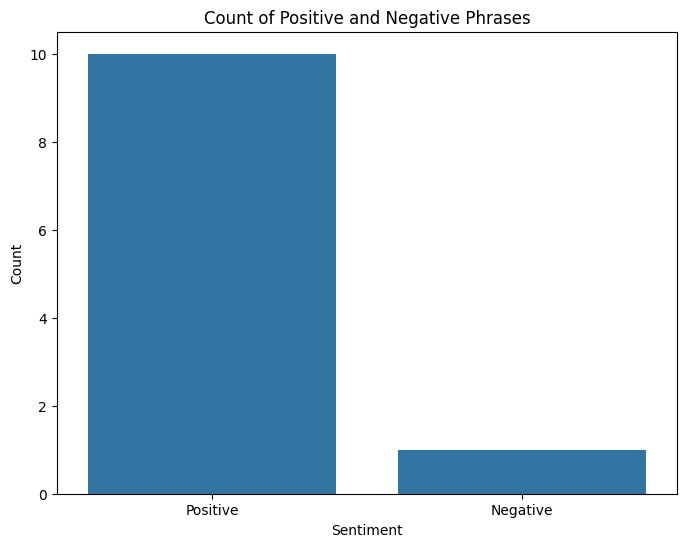

Average Sentiment Score: 0.8181818181818182
Resolution Time: 1.0
Agent Performance: 0.9090909090909091


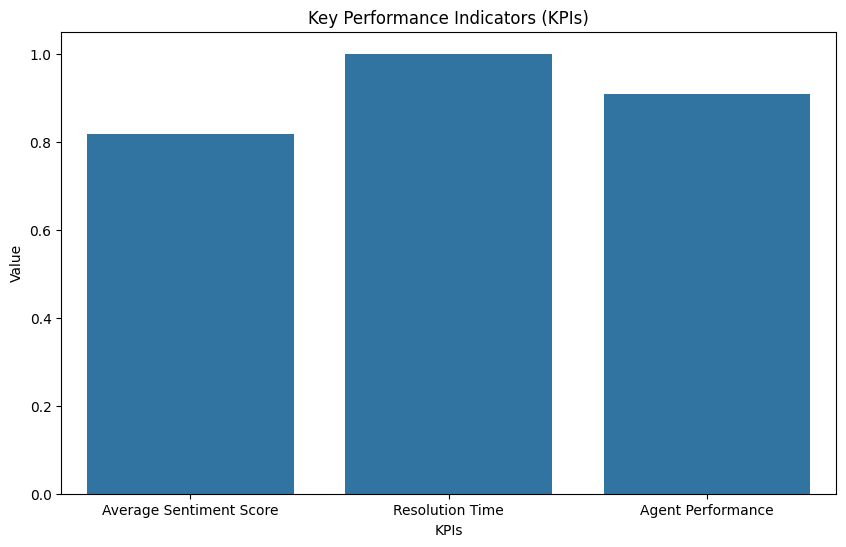

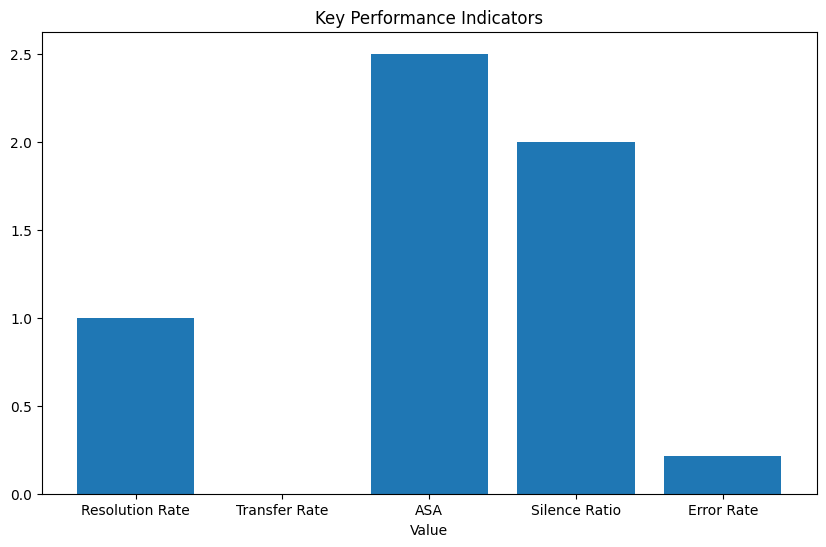

In [79]:
if transcriptions:
    total_transcriptions = len(transcriptions)
    categories, sentiments, positive_phrases_count, negative_phrases_count = classify_and_analyze(transcriptions)
    average_sentiment, resolution_time, agent_performance = calculate_kpis(categories, sentiments, positive_phrases_count, negative_phrases_count, total_transcriptions)
    display_classification_results(categories, sentiments, positive_phrases_count, negative_phrases_count)
    plot_kpis(average_sentiment, resolution_time, agent_performance)


    for conversation_text in transcriptions:
        # Calculate values for visualization
        resolution_rate = calculate_resolution_rate(conversation_text)
        transfer_rate = calculate_transfer_rate(conversation_text)
        asa = calculate_asa(conversation_text)
    error_rate_magnitudes = []
    for conversation_text in transcriptions:
        error_rate_magnitude = calculate_error_rate(conversation_text)
        error_rate_magnitudes.append(error_rate_magnitude)
    error_rate_mean = np.mean(error_rate_magnitudes)
      #Visualizing the about data
    functions = ['Resolution Rate','Transfer Rate', 'Average Speed of Answer', 'Silence Ratio','Error Rate']
    magnitudes = [ resolution_rate,transfer_rate, asa,silence_ratio_magnitude,error_rate_mean]

    plt.figure(figsize=(10, 6))
    plt.bar(functions, magnitudes)
    plt.xlabel('Value')
    plt.title('Key Performance Indicators')

else:
    print("No transcriptions available.")
